# Prédicteur de Charges d'Assurance Maladie (partie 2) :

* installation des packages : 

In [99]:
!pip install scipy
!pip install scikit-learn
!pip install xgboost


* Les imports : 

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

* Importer Datasets : 

In [101]:
data_frame = pd.read_csv("assurance-maladie-68d92978e362f464596651.csv")
print("data : \n", data_frame)

data : 
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


## ➕ Feature Story 1 : Analyse et Préparation des Données

### ▶️ Tâche 3 : Prétraitement des données  : 

* Gestion des valeurs manquantes (ex. : imputation avec la médiane pour les numériques ou le mode pour les catégoriques):

In [102]:
print("les valeurs null :\n", data_frame.isnull().sum())
df_new1 = data_frame.fillna({
    "bmi": data_frame["bmi"].median(),
    "age": data_frame["age"].median(),
    "children": data_frame["children"].median(),
    "charges": data_frame["charges"].median(),
    "sex": data_frame["sex"].mode()[0],
    "smoker": data_frame["smoker"].mode()[0],
    "region": data_frame["region"].mode()[0]
})

les valeurs null :
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [103]:
print(df_new1.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


* Suppression des doublons : 

In [104]:
# avant suppression : 
print("avant suppression :")
print("les doublons: ", df_new1.duplicated().sum())
print(df_new1.shape)

# après suppression : 
print("après suppression : ")
df_new2 = df_new1.drop_duplicates()
print(df_new2.shape)

avant suppression :
les doublons:  1
(1338, 7)
après suppression : 
(1337, 7)


* ================== Des fonctions du visualisation : ==================

In [105]:
def visual(column, data):
    sbs.histplot(data[column], kde=True)

    plt.title(f"Distribution de {column}")
    plt.xlabel(column)
    plt.ylabel("Densité")
    plt.show()

In [106]:

# ! visualization **********************************************
# def visualization(col, data):
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
#     sbs.boxplot(data=data, y=col, ax=axes[0])
#     axes[0].set_title(f'Boxplot de {col}')
    
#     sbs.histplot(data[col], kde=True, ax=axes[1])
#     axes[1].set_title(f'Distribution de {col}')
    
#     plt.show
    
    
def visualization(column, data, lower_limit=None, upper_limit=None):
    """
    Fonction de visualisation avec barres de limites
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Boxplot avec limites
    sbs.boxplot(data=data, y=column, ax=axes[0])
    if upper_limit is not None:
        axes[0].axhline(y=upper_limit, color='red', linestyle='--', linewidth=2, label=f'Limite sup: {upper_limit:.2f}')
    if lower_limit is not None:
        axes[0].axhline(y=lower_limit, color='red', linestyle='--', linewidth=2, label=f'Limite inf: {lower_limit:.2f}')
    axes[0].set_title(f'Boxplot de {column} avec limites IQR')
    axes[0].legend()
    
    # Histogramme avec limites
    sbs.histplot(data[column], kde=True, ax=axes[1])
    if upper_limit is not None:
        axes[1].axvline(x=upper_limit, color='red', linestyle='--', linewidth=2, label=f'Limite sup: {upper_limit:.2f}')
    if lower_limit is not None:
        axes[1].axvline(x=lower_limit, color='red', linestyle='--', linewidth=2, label=f'Limite inf: {lower_limit:.2f}')
    axes[1].set_title(f'Distribution de {column} avec limites IQR')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

#### 1️⃣ Z-score technique : (charges)

In [107]:

# ! detect_outliers_z_score ***********************************

def detect_outliers_z_score(data, column, seuil=3):
    df_analyser = data.copy()
    
    mean_val = df_analyser[column].mean()
    std_val = df_analyser[column].std()
    df_analyser[f'{column}_zscore'] = np.abs((df_analyser[column] - mean_val) / std_val)
    
    outliers = df_analyser[df_analyser[f'{column}_zscore'] > seuil]
    
    print(f"Moyenne de {column} : {mean_val:.2f}")
    print(f"Ecrat-type de {column} : {std_val:.2f}")
    print(f"Seuil Z-score -+{seuil} ")
    print(f"Limites: [{mean_val - seuil * std_val:.2f}, {mean_val + seuil * std_val:.2f} ]")
    print(f"Outliers détectés : {len(outliers)}")
    print("df_new2.head() : \n", df_analyser.head())
    
    print("La distribution des charges normaliser : ")
    visualization(f"{column}_zscore", df_analyser) 
    
    return outliers, mean_val, std_val

# ! detect_and_remote_outliers_z_score ************************

def detect_and_remote_outliers_z_score(data, column, seuil=3):
    df_clean = data.copy()
    
    mean_val = df_clean[column].mean()
    std_val = df_clean[column].std()
    
    sup_limit = mean_val + seuil * std_val
    inf_limit = mean_val - seuil * std_val
    
    print(f"**** suppression des outliers ({column.upper()}) ****")
    print(f"Moyenne: {mean_val:.2f}")
    print(f"Ecart-type: {std_val:.2f}")
    print(f"Limites Z-SCORE {seuil} : [{inf_limit:.2f}, {sup_limit:.2f}")
    
    outliers_mask = (df_clean[column] < inf_limit) | (df_clean[column] > sup_limit)
    n_outliers = outliers_mask.sum()
    
    print(f"Nombre des outliers détectés : {n_outliers}")
    print(f"Pourcentage d'outliers: {(n_outliers/len(df_clean))*100:.2f}")
    
    print("La distribution des charges normaliser : ")
    visualization(column, df_clean, inf_limit, sup_limit) 
    
    outliers_removed = df_clean[outliers_mask].copy()
    
    df_clean = df_clean[~outliers_mask]
    
    print(f"Taille avant suppression : {len(data)}")
    print(f"Taille après suppression : {len(df_clean)}")
    print(f"Lignes supprimées : {n_outliers}")
    
    return df_clean, outliers_removed, inf_limit, sup_limit 

# ! ==================================================================


📌 Avant Appliquer la technique Z-score : 

C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


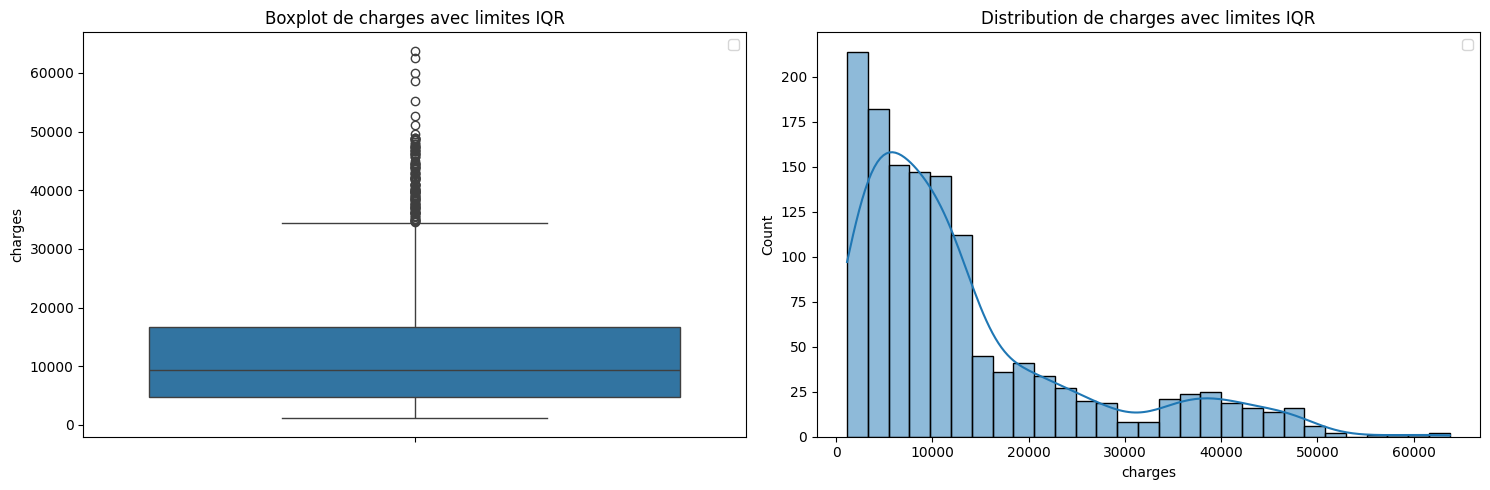

In [108]:
titre = "Avant Appliquer la technique Z-score :"
visualization("charges", df_new2)

📌 Après Appliquer La technique Z-score : 

Moyenne de charges : 13279.12
Ecrat-type de charges : 12110.36
Seuil Z-score -+3 
Limites: [-23051.96, 49610.20 ]
Outliers détectés : 7
df_new2.head() : 
    age     sex     bmi  children smoker     region      charges  \
0   19  female  27.900         0    yes  southwest  16884.92400   
1   18    male  33.770         1     no  southeast   1725.55230   
2   28    male  33.000         3     no  southeast   4449.46200   
3   33    male  22.705         0     no  northwest  21984.47061   
4   32    male  28.880         0     no  northwest   3866.85520   

   charges_zscore  
0        0.297745  
1        0.954024  
2        0.729100  
3        0.718835  
4        0.777208  
La distribution des charges normaliser : 


C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


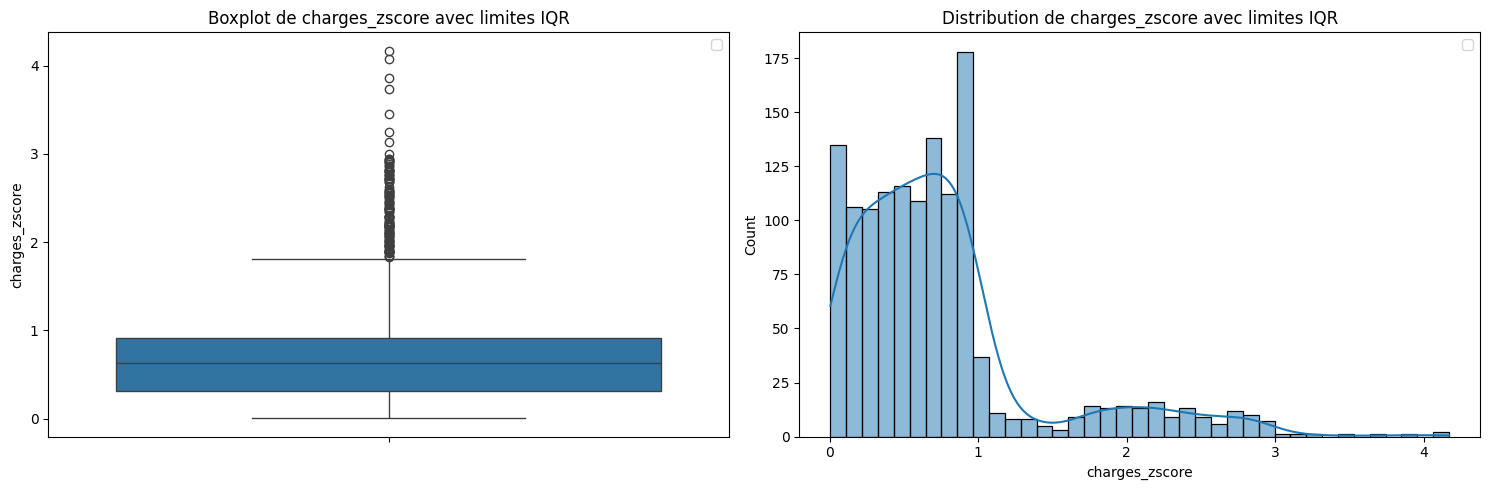

In [109]:
outliers_charges, mean_charges, std_charges = detect_outliers_z_score(df_new2, "charges", seuil=3)

📌 Suppression des outliers avec Z-score > 3 : 

**** suppression des outliers (CHARGES) ****
Moyenne: 13270.42
Ecart-type: 12110.01
Limites Z-SCORE 3 : [-23059.61, 49600.46
Nombre des outliers détectés : 7
Pourcentage d'outliers: 0.52
La distribution des charges normaliser : 


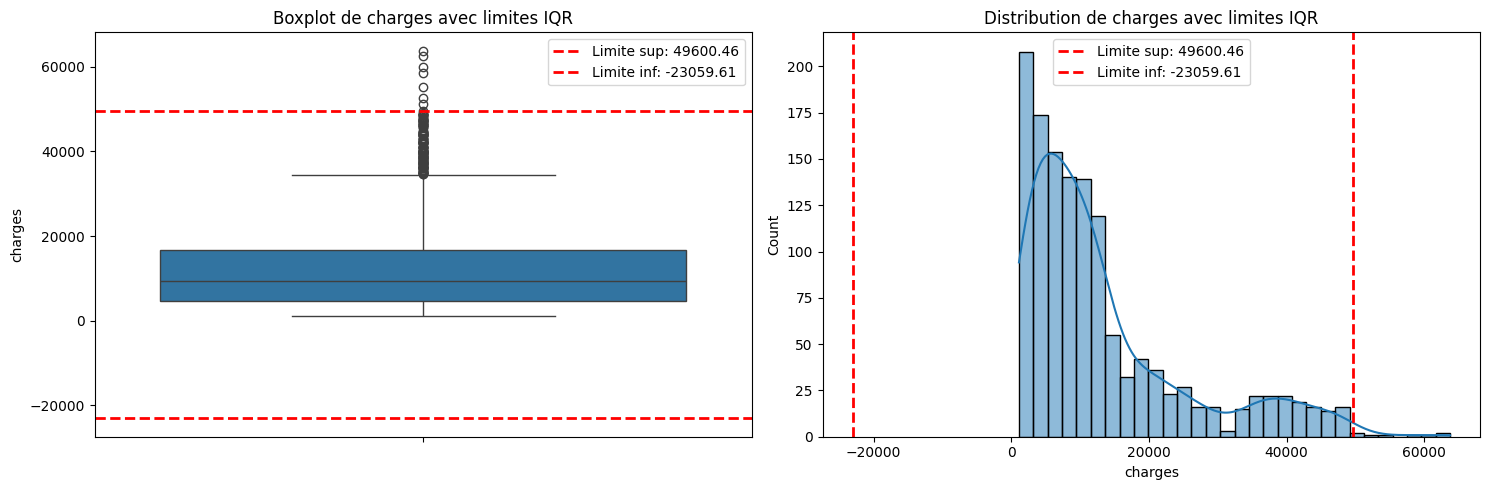

Taille avant suppression : 1338
Taille après suppression : 1331
Lignes supprimées : 7


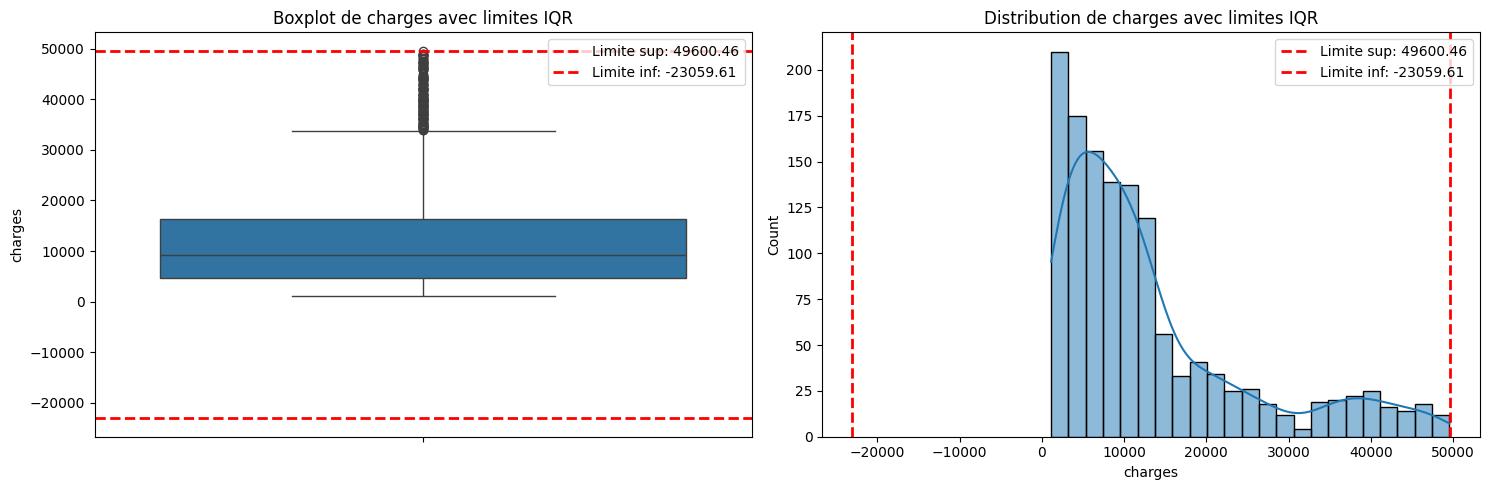

In [110]:
# Suppression des outliers avec Z-score > 3
data_clean, outliers_removed, lower_limit, upper_limit = detect_and_remote_outliers_z_score(data_frame, 'charges', seuil=3)

visualization('charges', data_clean, lower_limit, upper_limit)


#### 2️⃣ IQR technique : (bmi)

In [111]:
def detect_outliers_iqr(data, column):
    """
    Détection des valeurs aberrantes avec méthode IQR
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    print("shape : ", data.shape)
    print("25% (Q1) : ", Q1)
    print("75% (Q3) : ", Q3)
    
    IQR = Q3 - Q1
    print("IQR : ", IQR)
    
    bande_inf = Q1 - 1.5 * IQR
    bande_sup = Q3 + 1.5 * IQR 
    
    outliers = data[(data[column] < bande_inf) | (data[column] > bande_sup)]
    
    return outliers, bande_inf, bande_sup, IQR


📌 Avant appliquer la technique IQR : 

C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\ramas\AppData\Local\Temp\ipykernel_26888\365289297.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


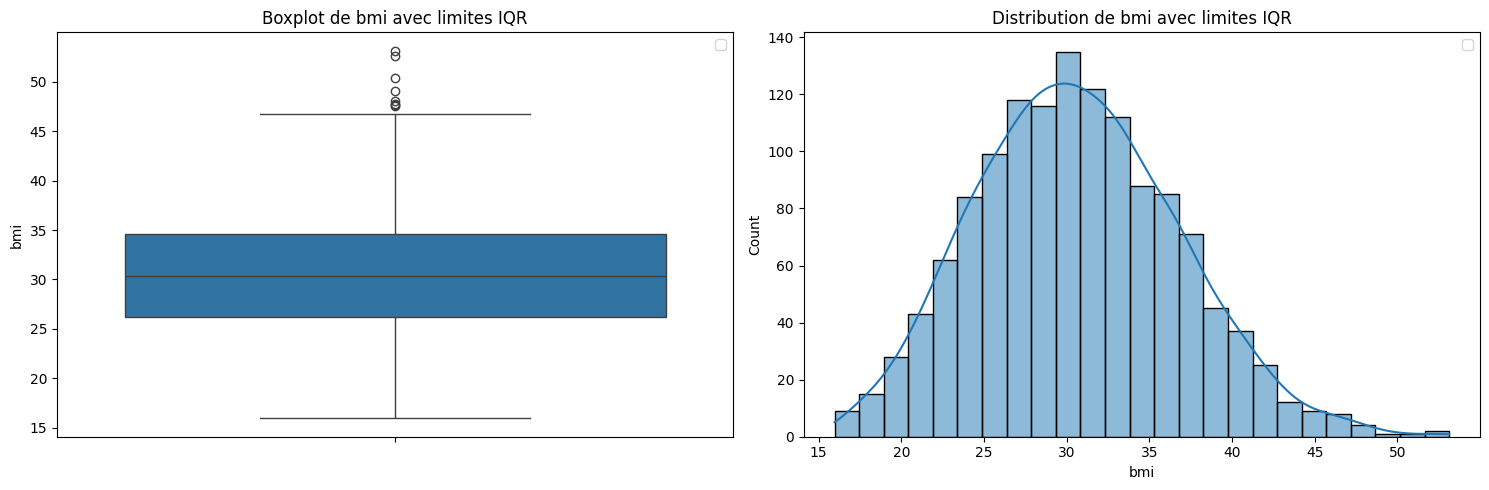

In [112]:
visualization("bmi", data_clean)

In [113]:
print(f"\n*************** Analyse de bmi ***************:")
outliers, lower, upper, iqr = detect_outliers_iqr(data_clean, "bmi")

print(f"IQR de bmi: {iqr:.2f}")
print(f"Bornes: [{lower:.2f}, {upper:.2f}]")
print(f"Nombre de valeurs aberrantes: {len(outliers)}")
print(f"Pourcentage: {(len(outliers)/len(data_clean))*100:.2f}%")

if len(outliers) > 0:
    print(f"Valeurs aberrantes min: {outliers['bmi'].min():.2f}")
    print(f"Valeurs aberrantes max: {outliers['bmi'].max():.2f}")

outliers_info = {}

# Application sur bmi
outliers, lower, upper, iqr = detect_outliers_iqr(data_clean, 'bmi')
outliers_info['bmi'] = {
    'outliers': outliers,
    'lower': lower,
    'upper': upper,
    'count': len(outliers)
}



*************** Analyse de bmi ***************:
shape :  (1331, 7)
25% (Q1) :  26.22
75% (Q3) :  34.6
IQR :  8.380000000000003
IQR de bmi: 8.38
Bornes: [13.65, 47.17]
Nombre de valeurs aberrantes: 8
Pourcentage: 0.60%
Valeurs aberrantes min: 47.52
Valeurs aberrantes max: 53.13
shape :  (1331, 7)
25% (Q1) :  26.22
75% (Q3) :  34.6
IQR :  8.380000000000003



=== VISUALISATION AVEC LIMITES IQR ===


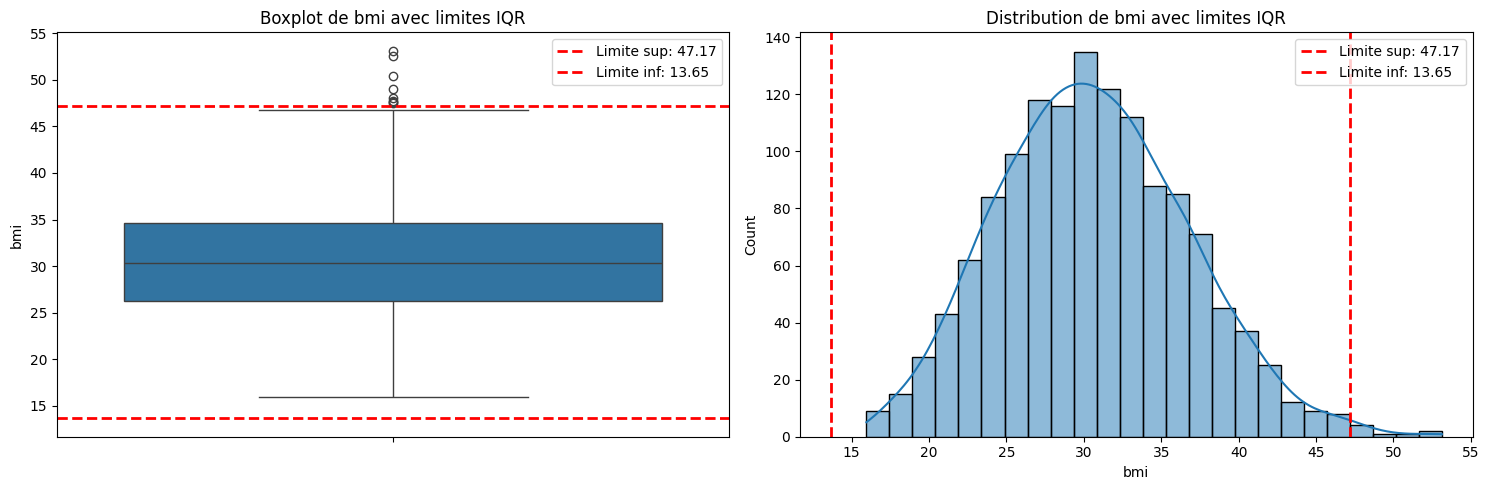


Outliers détectés:
       bmi
116  49.06
286  48.07
401  47.52
847  50.38
860  47.60


In [114]:

print("\n=== VISUALISATION AVEC LIMITES IQR ===")
# visual("bmi", data_clean)
visualization("bmi", data_clean, lower, upper)

print("\nOutliers détectés:")
print(outliers[['bmi']].head())


📌 Suppression des outliers de bmi : 

In [115]:

print("\n=== SUPPRESSION DES OUTLIERS ===")
initial_size = len(data_clean)

# Suppression des outliers de bmi
outliers_bmi = outliers_info['bmi']['outliers']
df_new3 = data_clean[~data_clean.index.isin(outliers_bmi.index)]

print(f"Taille avant suppression: {initial_size}")
print(f"Taille après suppression: {len(df_new3)}") 
print(f"Lignes supprimées: {initial_size - len(df_new3)}")



=== SUPPRESSION DES OUTLIERS ===
Taille avant suppression: 1331
Taille après suppression: 1323
Lignes supprimées: 8


📌 Visualisation après suppression : 


=== VISUALISATION APRÈS SUPPRESSION ===


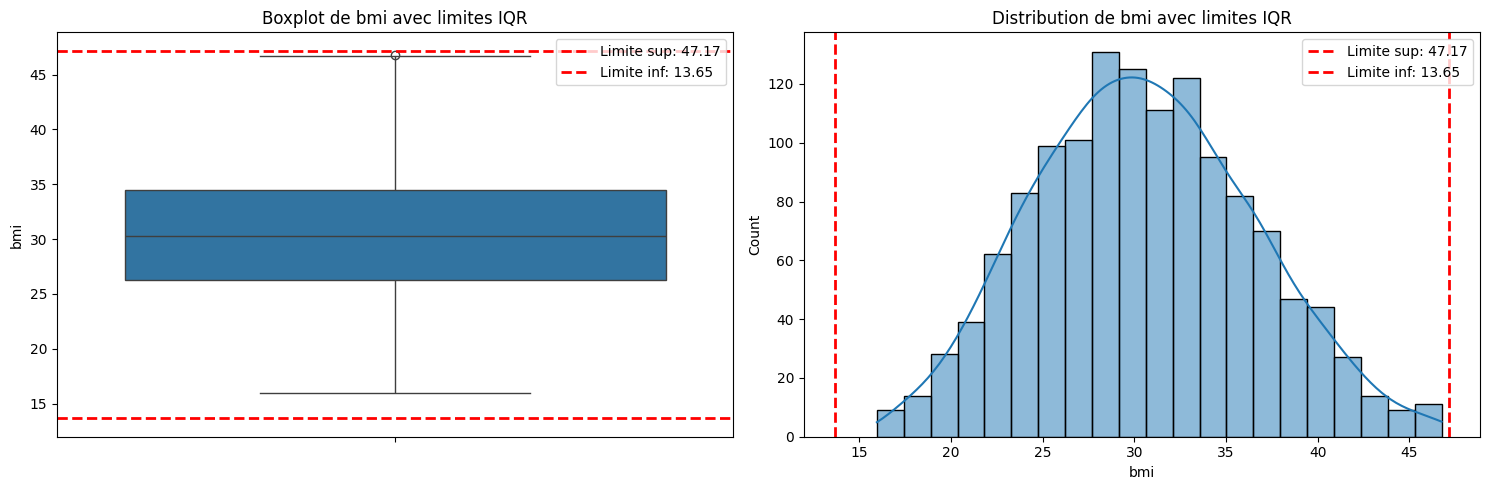

In [116]:

print("\n=== VISUALISATION APRÈS SUPPRESSION ===")
# visual("bmi", df_new3)
visualization("bmi", df_new3, lower, upper)


📌 Statistiques finales : 

In [117]:
print("\n=== STATISTIQUES FINALES ===")
print(f"BMI moyen avant: {data_clean['bmi'].mean():.2f}")
print(f"BMI moyen après: {df_new3['bmi'].mean():.2f}")
print(f"Écart-type avant: {data_clean['bmi'].std():.2f}")
print(f"Écart-type après: {df_new3['bmi'].std():.2f}")


=== STATISTIQUES FINALES ===
BMI moyen avant: 30.63
BMI moyen après: 30.52
Écart-type avant: 6.09
Écart-type après: 5.92


📌 Analyse des outliers supprimés : 

In [118]:

print("\n=== ANALYSE DES OUTLIERS SUPPRIMÉS ===")
if len(outliers_bmi) > 0:
    print("Caractéristiques des outliers de BMI supprimés:")
    print(f"  - BMI moyen des outliers: {outliers_bmi['bmi'].mean():.2f}")
    print(f"  - Âge moyen des outliers: {outliers_bmi['age'].mean():.1f} ans")
    print(f"  - Pourcentage de fumeurs: {(outliers_bmi['smoker'] == 'yes').mean()*100:.1f}%")
    print(f"  - Charges moyennes: {outliers_bmi['charges'].mean():.2f}")


=== ANALYSE DES OUTLIERS SUPPRIMÉS ===
Caractéristiques des outliers de BMI supprimés:
  - BMI moyen des outliers: 49.51
  - Âge moyen des outliers: 37.9 ans
  - Pourcentage de fumeurs: 25.0%
  - Charges moyennes: 16607.94


* DataFrame apres la gestion des valeurs aberrantes : 

In [119]:
print("Dataset initial : ", data_frame.shape)
print("Après Z_score (charges) : ", data_clean.shape)
print("Après IQR (BMI) : ", df_new3.shape)
df_new3.to_csv("df_new3.csv", index=False)

Dataset initial :  (1338, 7)
Après Z_score (charges) :  (1331, 7)
Après IQR (BMI) :  (1323, 7)


* Encoder les variables catégoriques (sexe, smoker, région) avec one-hot encoding ou label encoding : 

In [120]:
def one_hot_encoding(data):
    
    df = data.copy()
    
    print("=== ENCODAGE OPTIMISÉ ===")
    print(f"Dataset initial: {df.shape}")
    
    df['sex'] = df['sex'].map({'male': 0, 'female': 1})
    df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
    
    regions = pd.get_dummies(df['region'], prefix='region', drop_first=True)
    df = pd.concat([df, regions], axis=1)
    df = df.drop('region', axis=1)
    
    print(f"Dataset final : {df.shape}")
    print(f"Colonnes encodées : {df.columns.tolist()}")
    
    return df



In [121]:
data_encoding = one_hot_encoding(df_new3)
print(data_encoding)

data_encoding.to_csv("data_encoding.csv", index=False)


=== ENCODAGE OPTIMISÉ ===
Dataset initial: (1323, 7)
Dataset final : (1323, 9)
Colonnes encodées : ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']
      age  sex     bmi  children  smoker      charges  region_northwest  \
0      19    1  27.900         0       1  16884.92400             False   
1      18    0  33.770         1       0   1725.55230             False   
2      28    0  33.000         3       0   4449.46200             False   
3      33    0  22.705         0       0  21984.47061              True   
4      32    0  28.880         0       0   3866.85520              True   
...   ...  ...     ...       ...     ...          ...               ...   
1333   50    0  30.970         3       0  10600.54830              True   
1334   18    1  31.920         0       0   2205.98080             False   
1335   18    1  36.850         0       0   1629.83350             False   
1336   21    1  25.800         0    

* Diviser les données en ensembles d'entraînement et de test (80% / 20%) avec traintestsplit de Scikit-learn: 

In [122]:
def diviser_test_train(data, target="charges"):
    X = data.drop(target, axis=1)
    y = data[target]
    
    print("\n\nTarget y : \n",y.shape, "\n", y.head())
    print("\n\nFeature X : \n",X.shape,  "\n", X.head() )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=0.2,
        random_state=42,
        shuffle=True,
        stratify=None
    )
    
    print(f"X_train: {X_train.shape} ({X_train.shape[0]/len(data)*100:.1f}%)")
    print(f"X_test: {X_test.shape} ({X_test.shape[0]/len(data)*100:.1f}%)")
    print(f"y_train: {y_train.shape} ({y_train.shape[0]/len(data)*100:.1f}%)")
    print(f"y_test: {y_test.shape} ({y_test.shape[0]/len(data)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test, X, y
    

In [123]:
X_train, X_test, y_train, y_test, X, y = diviser_test_train(data_encoding)




Target y : 
 (1323,) 
 0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


Feature X : 
 (1323, 8) 
    age  sex     bmi  children  smoker  region_northwest  region_southeast  \
0   19    1  27.900         0       1             False             False   
1   18    0  33.770         1       0             False              True   
2   28    0  33.000         3       0             False              True   
3   33    0  22.705         0       0              True             False   
4   32    0  28.880         0       0              True             False   

   region_southwest  
0              True  
1             False  
2             False  
3             False  
4             False  
X_train: (1058, 8) (80.0%)
X_test: (265, 8) (20.0%)
y_train: (1058,) (80.0%)
y_test: (265,) (20.0%)


📌 Distribution de la target : 

In [124]:
print(f"\n************* DISTRIBUTION DE LA TARGET *************")
print(f"Target moyenne - Dataset complet: {y.mean():.2f}")
print(f"Target moyenne - Train: {y_train.mean():.2f}")
print(f"Target moyenne - Test:  {y_test.mean():.2f}")

print(f"\nÉcart-type - Dataset complet: {y.std():.2f}")
print(f"Écart-type - Train: {y_train.std():.2f}")
print(f"Écart-type - Test:  {y_test.std():.2f}")


************* DISTRIBUTION DE LA TARGET *************
Target moyenne - Dataset complet: 13015.18
Target moyenne - Train: 13101.26
Target moyenne - Test:  12671.53

Écart-type - Dataset complet: 11657.45
Écart-type - Train: 11836.89
Écart-type - Test:  10926.29


6️⃣ Appliquer une normalisation (MinMaxScaler) ou une standardisation (StandardScaler) sur les variables numériques pour harmoniser les échelles : 

🧷 Normalisation (MinMaxScaler) : 

In [125]:
num_columns = ["age", "bmi", "children", "charges"]

minmax_scaller = MinMaxScaler()
x_train_normaliser = minmax_scaller.fit_transform(X_train)
x_test_normaliser = minmax_scaller.transform(X_test)

print("**************** MinMaxScaler : *****************")
print("x_train_normaliser : \n",x_train_normaliser)
print("x_test_normaliser : \n",x_test_normaliser)

**************** MinMaxScaler : *****************
x_train_normaliser : 
 [[0.10869565 1.         0.39001169 ... 0.         1.         0.        ]
 [0.54347826 0.         0.63988642 ... 0.         1.         0.        ]
 [0.47826087 0.         0.46968432 ... 1.         0.         0.        ]
 ...
 [0.15217391 1.         0.44713546 ... 0.         0.         1.        ]
 [0.15217391 1.         0.25004176 ... 0.         0.         1.        ]
 [0.17391304 1.         0.18089193 ... 1.         0.         0.        ]]
x_test_normaliser : 
 [[ 0.65217391  1.          0.34908969 ...  0.          0.
   0.        ]
 [ 0.7173913   1.          0.75780859 ...  0.          0.
   1.        ]
 [ 0.80434783  1.          0.33355604 ...  0.          0.
   1.        ]
 ...
 [ 0.97826087  1.          0.61416402 ...  0.          1.
   0.        ]
 [ 0.58695652  0.          0.11808919 ...  0.          1.
   0.        ]
 [ 0.          0.         -0.02856188 ...  0.          0.
   0.        ]]


🧷 Standardisation (StandardScaler) : 

In [126]:
num_columns = ["age", "bmi", "children"]

standar_scaler = StandardScaler()
X_train_scaled = standar_scaler.fit_transform(X_train)
X_test_scaled = standar_scaler.transform(X_test)

print("**************** StandardScaler : *****************")
print("X_train_scaled : \n",X_train_scaled)
print("X_test_scaled : \n",X_test_scaled)

**************** StandardScaler : *****************
X_train_scaled : 
 [[-1.15412097  1.         -0.31867676 ... -0.57662267  1.61583461
  -0.55915569]
 [ 0.28887121 -1.          0.95530908 ... -0.57662267  1.61583461
  -0.55915569]
 [ 0.07242239 -1.          0.08753397 ...  1.73423636 -0.61887522
  -0.55915569]
 ...
 [-1.00982175  1.         -0.02743133 ... -0.57662267 -0.61887522
   1.78841066]
 [-1.00982175  1.         -1.03231321 ... -0.57662267 -0.61887522
   1.78841066]
 [-0.93767214  1.         -1.38487346 ...  1.73423636 -0.61887522
  -0.55915569]]
X_test_scaled : 
 [[ 0.64961926  1.         -0.52731749 ... -0.57662267 -0.61887522
  -0.55915569]
 [ 0.86606809  1.          1.55653501 ... -0.57662267 -0.61887522
   1.78841066]
 [ 1.15466652  1.         -0.60651581 ... -0.57662267 -0.61887522
   1.78841066]
 ...
 [ 1.7318634   1.          0.82416348 ... -0.57662267  1.61583461
  -0.55915569]
 [ 0.43317043 -1.         -1.70507311 ... -0.57662267  1.61583461
  -0.55915569]
 [-1.5148

💾 Sauvegarder des données : 

In [127]:
def save_datasets(X_train, X_test, y_train, y_test, prefix=''):
    
    # Recréer les DataFrames directement
    train_df = pd.DataFrame(X_train)
    train_df['charges'] = y_train
    
    test_df = pd.DataFrame(X_test)
    test_df['charges'] = y_test
    
    train_file = f'{prefix}train_set.csv'
    test_file = f'{prefix}test_set.csv'
    
    train_df.to_csv(train_file, index=False)
    test_df.to_csv(test_file, index=False)
    
    print(f"\nFichiers sauvegardés:")
    print(f"  - {train_file} ({len(train_df)} observations)")
    print(f"  - {test_file} ({len(test_df)} observations)")
    
    return train_df, test_df



In [128]:
# Sauvegarde des données
train_df, test_df = save_datasets(X_train_scaled, X_test_scaled, y_train, y_test, 'assurance_')


Fichiers sauvegardés:
  - assurance_train_set.csv (1058 observations)
  - assurance_test_set.csv (265 observations)


## ➕ Feature Story 2 : Entraînement des Modèles de Régression

### ▶️ Tâche 1 : Entraîner et Évaluer les performances des modèles

#### *️⃣ Régression linéaire (LinearRegression) : 

In [129]:

model1 = LinearRegression()

model1.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [130]:
y_pred1 = model1.predict(X_test_scaled)

In [131]:

r2 = r2_score(y_test, y_pred1)

print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.7056


In [132]:

mae = mean_absolute_error(y_test, y_pred1)
print(f"mean absolute error (MAE): {mae:.4f}")


mean absolute error (MAE): 4070.9857


In [133]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f"mean squared error (RMSE): {rmse:.4f}")

mean squared error (RMSE): 5917.4579


#### *️⃣ Random Forest (RandomForestRegressor) : 

In [134]:

model2 = RandomForestRegressor(n_estimators=10, random_state=42)

model2.fit(X_train_scaled, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [135]:
y_pred2 = model2.predict(X_test_scaled)

In [136]:

r2 = r2_score(y_test, y_pred2)

print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.7986


In [137]:

mae = mean_absolute_error(y_test, y_pred2)
print(f"mean absolute error (MAE): {mae:.4f}")


mean absolute error (MAE): 2679.4331


In [138]:

rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f"mean squared error (RMSE): {rmse:.4f}")

mean squared error (RMSE): 4894.2277


#### *️⃣ XGBoost (XGBRegressor): : 

In [139]:

model3 = XGBRegressor(random_state=42, eval_metric='rmse')

model3.fit(X_train_scaled, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [140]:
y_pred3 = model3.predict(X_test_scaled)

In [141]:

r2 = r2_score(y_test, y_pred3)

print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.7702


In [142]:

mae = mean_absolute_error(y_test, y_pred3)
print(f"mean absolute error (MAE): {mae:.4f}")


mean absolute error (MAE): 2986.5288


In [143]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred3))
print(f"mean squared error (RMSE): {rmse:.4f}")

mean squared error (RMSE): 5227.6621


#### *️⃣ SVR (SVR) : 

In [144]:

model4 = SVR()

model4.fit(X_train_scaled, y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [145]:
y_pred4 = model4.predict(X_test_scaled)


In [146]:

r2 = r2_score(y_test, y_pred4)

print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): -0.1048


In [147]:

mae = mean_absolute_error(y_test, y_pred4)
print(f"mean absolute error (MAE): {mae:.4f}")


mean absolute error (MAE): 7438.9490


In [148]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred4))
print(f"mean squared error (RMSE): {rmse:.4f}")

mean squared error (RMSE): 11462.9544


#### #️⃣ sans utiliser le pipeline : 

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    'LR': LinearRegression(),
    'RFR': RandomForestRegressor(n_estimators=10, random_state=42),
    'XGBR': XGBRegressor(random_state=42, eval_metric='rmse'),
    'SVR': SVR()
    }

resultats = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultats.append({'model': name, 'rmse': rmse, 'mae': mae, 'r2': r2})
    
    
pd.DataFrame(resultats).sort_values('rmse')


,model,rmse,mae,r2
1,RFR,2.395346e+07,2679.433081,0.798598
2,XGBR,2.732845e+07,2986.528780,0.770220
0,LR,3.501631e+07,4070.985680,0.705580
3,SVR,1.313993e+08,7438.949009,-0.104815


#### #️⃣ utiliser le pipeline : 

In [150]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_new3.to_csv("df_new3.csv", index=False)
X_train, X_test, y_train, y_test, X, y = diviser_test_train(
    df_new3
)

num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']


num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
('num', num_pipeline, num_features),
('cat', cat_pipeline, cat_features)
])



Target y : 
 (1323,) 
 0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


Feature X : 
 (1323, 6) 
    age     sex     bmi  children smoker     region
0   19  female  27.900         0    yes  southwest
1   18    male  33.770         1     no  southeast
2   28    male  33.000         3     no  southeast
3   33    male  22.705         0     no  northwest
4   32    male  28.880         0     no  northwest
X_train: (1058, 6) (80.0%)
X_test: (265, 6) (20.0%)
y_train: (1058,) (80.0%)
y_test: (265,) (20.0%)


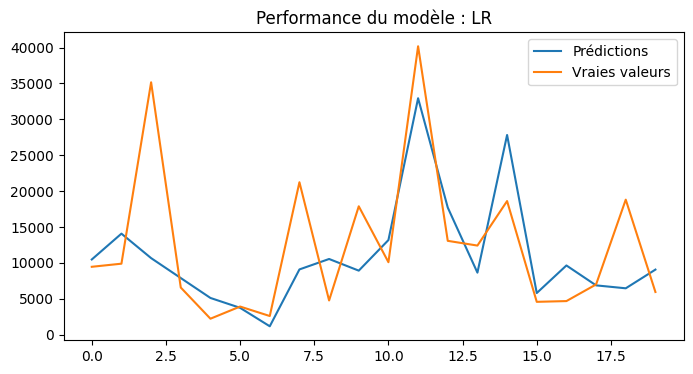

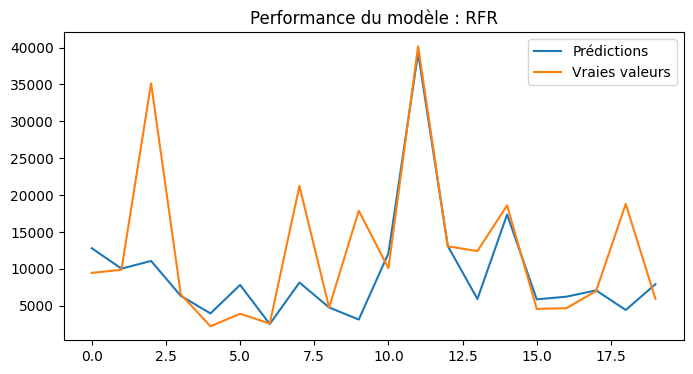

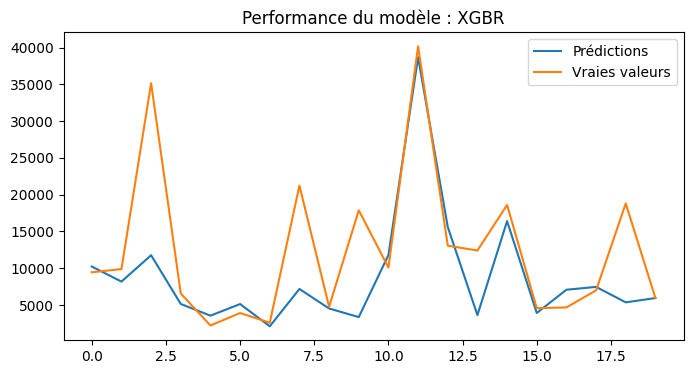

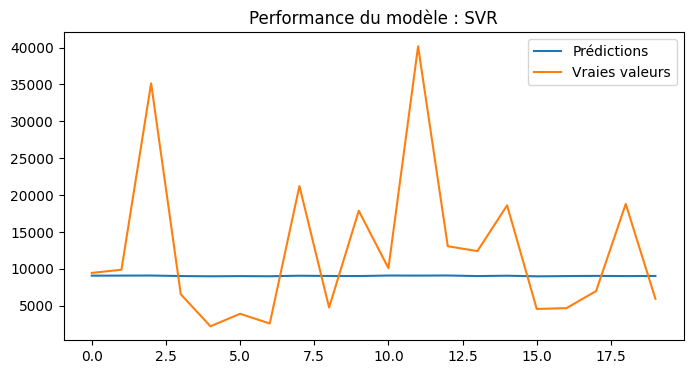

,model,rmse,mae,r2
1,RFR,4835.641801,2601.282150,0.803390
2,XGBR,5260.971929,2956.001339,0.767283
0,LR,5917.457946,4070.985680,0.705580
3,SVR,11467.497330,7433.028409,-0.105691


In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

models = {
    'LR': LinearRegression(),
    'RFR': RandomForestRegressor(n_estimators=10, random_state=42),
    'XGBR': XGBRegressor(random_state=42, eval_metric='rmse'),
    'SVR': SVR()
    }
resultats = []

for name, m in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', m)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    plt.figure(figsize=(8, 4))
    plt.title(f'Performance du modèle : {name}')
    plt.plot(list(preds)[:20], label='Prédictions')
    plt.plot(list(y_test)[:20], label='Vraies valeurs')
    plt.legend()
    plt.show()
    resultats.append({'model': name, 'rmse': rmse, 'mae': mae, 'r2': r2})


import pandas as pd
pd.DataFrame(resultats).sort_values('rmse')



#### #️⃣ Évaluer les performances des modèles sur l'ensemble de test en utilisant les métriques RMSE (meansquarederror), MAE (meanabsoluteerror), et R² (r2_score): 

<table>
  <thead>
    <tr>
      <th>Modèle</th>
      <th>RMSE</th>
      <th>MAE</th>
      <th>R²</th>
      <th>Interprétation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>RFR</strong></td>
      <td><strong>4835</strong></td>
      <td><strong>2601</strong></td>
      <td><strong>0.803</strong></td>
      <td>C’est le meilleur modèle : il fait peu d’erreurs (≈2600$ en moyenne) et explique 80% des variations des charges. Très solide.</td>
    </tr>
    <tr>
      <td><strong>XGBR</strong></td>
      <td>5261</td>
      <td>2956</td>
      <td>0.767</td>
      <td>Bon modèle : il se rapproche de Random Forest, mais un peu moins précis. Peut être amélioré par tuning.</td>
    </tr>
    <tr>
      <td><strong>LR</strong></td>
      <td>5917</td>
      <td>4071</td>
      <td>0.706</td>
      <td>Modèle de base correct : il explique ~70% des variations, mais reste moins précis car trop simple.</td>
    </tr>
    <tr>
      <td><strong>SVR</strong></td>
      <td>11467</td>
      <td>7433</td>
      <td>-0.106</td>
      <td>Mauvais modèle : il se trompe beaucoup et n’explique pas bien les données. Paramètres par défaut inadaptés.</td>
    </tr>
  </tbody>
</table>


Les performances initiales montrent que le RandomForestRegressor est le plus performant avec un RMSE ≈ 4800$, un MAE ≈ 2600$ et un R² ≈ 0.80, ce qui indique qu’il explique 80% de la variance des charges médicales. Le modèle XGBoost obtient des résultats proches, tandis que la régression linéaire reste correcte mais moins précise. Le modèle SVR, en revanche, échoue avec un R² négatif. Ces résultats serviront de base avant l’optimisation des hyperparamètres.

#### #️⃣ Enregistrer les résultats pour comparaison ultérieure : 

In [152]:
df_res = pd.DataFrame(resultats)

df_res = df_res.sort_values('rmse')

# Enregistrer dans un file CSV
df_res.to_csv("models_results.csv", index=False)


## ➕ Feature Story 3 : Tuning des Hyperparamètres :

### 1️⃣ Sélectionner les modèles les plus performants (RFR et XGBR) : 


In [153]:

the_best_models = {
    'RFR': RandomForestRegressor(random_state=42),
    'XGBR': XGBRegressor(random_state=42, eval_metric='rmse'),
}

### 2️⃣ Définir une grille de recherche (GridSearchCV) ou aléatoire (RandomizedSearchCV) avec validation croisée (5 folds) pour les hyperparamètres (ex. : pour Random Forest : nestimators, maxdepth, minsamplessplit ; pour XGBoost : learningrate, maxdepth, subsample) : 


In [154]:
param_grid = {
    'RFR':{
        'n_estimators': [100, 200],
        'max_depth': [ 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'XGBR':{
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8]
    }
}

### 4️⃣ Réentraîner les modèles avec les hyperparamètres optimisés sur l'ensemble d'entraînement complet :

#### ▶️ sans utiliser un pipeline : 

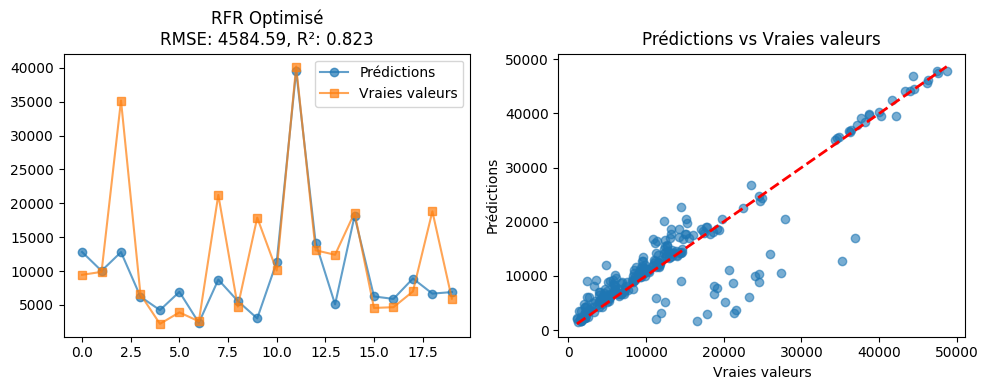

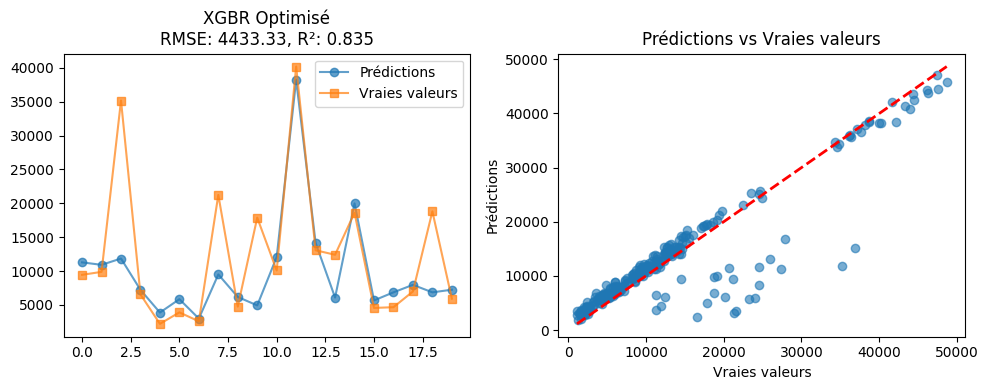

,model,rmse,mae,r2
1,XGBR,4433.331409,2467.528092,0.834744
0,RFR,4584.592349,2507.609874,0.823275


In [155]:
resultats = []

for name, model in the_best_models.items():
    # 
    model_cv = GridSearchCV(
        estimator=the_best_models[name], 
        param_grid=param_grid[name], 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    #  
    
    model_cv.fit(X_train_scaled, y_train)
    
    y_pred = model_cv.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Visualisation
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(y_pred[:20], 'o-', label='Prédictions', alpha=0.7)
    plt.plot(y_test.values[:20], 's-', label='Vraies valeurs', alpha=0.7)
    plt.title(f'{name} Optimisé\nRMSE: {rmse:.2f}, R²: {r2:.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Vraies valeurs')
    plt.ylabel('Prédictions')
    plt.title('Prédictions vs Vraies valeurs')
    
    plt.tight_layout()
    plt.show()
    # 
    
    resultats.append({'model': name, 'rmse': rmse, 'mae': mae, 'r2': r2})
    
    
pd.DataFrame(resultats).sort_values('rmse')



#### ▶️ utiliser un pipeline : 



Target y : 
 (1323,) 
 0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


Feature X : 
 (1323, 6) 
    age     sex     bmi  children smoker     region
0   19  female  27.900         0    yes  southwest
1   18    male  33.770         1     no  southeast
2   28    male  33.000         3     no  southeast
3   33    male  22.705         0     no  northwest
4   32    male  28.880         0     no  northwest
X_train: (1058, 6) (80.0%)
X_test: (265, 6) (20.0%)
y_train: (1058,) (80.0%)
y_test: (265,) (20.0%)

=== Optimisation de RFR ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres RFR: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Meilleur score CV: 4401.13


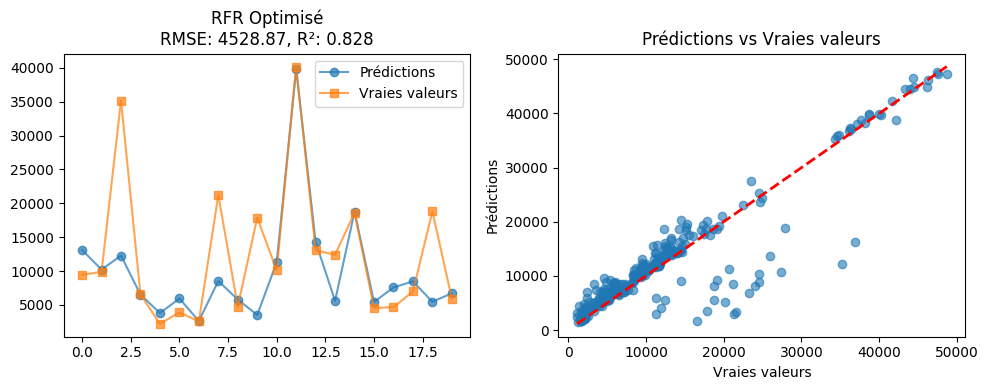


=== Optimisation de XGBR ===
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Meilleurs paramètres XGBR: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.8}
Meilleur score CV: 4338.02


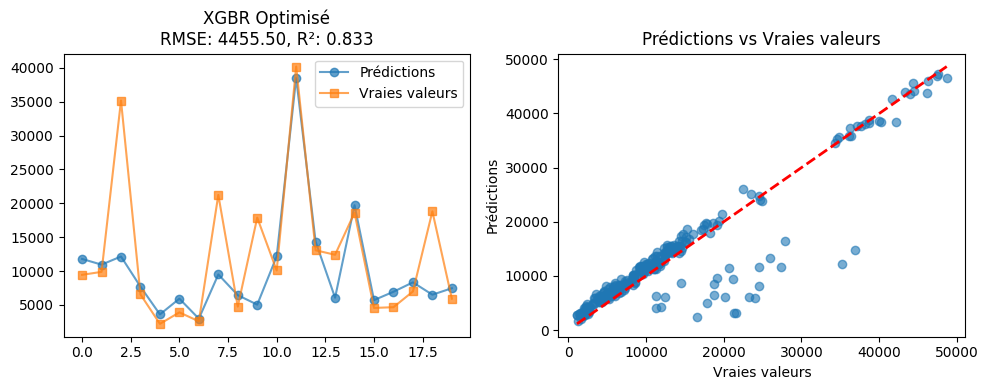

In [156]:

X_train, X_test, y_train, y_test, X, y = diviser_test_train(
    df_new3
)

# Définition des modèles avec pipelines
the_best_models = {
    'RFR': Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBR': Pipeline([
        ('pre', preprocessor),
        ('model', XGBRegressor(random_state=42, eval_metric='rmse'))
    ])
}

# Grille d'hyperparamètres AVEC le préfixe 'model__'
param_grid = {
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'XGBR': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [3, 5, 7, 10],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    }
}

resultats_optimises = []
y_preds = []

for name, model_pipe in the_best_models.items():
    print(f"\n=== Optimisation de {name} ===")
    
    model_cv = GridSearchCV(
        estimator=model_pipe, 
        param_grid=param_grid[name], 
        cv=5, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    model_cv.fit(X_train, y_train)
    
    print(f"Meilleurs paramètres {name}: {model_cv.best_params_}")
    print(f"Meilleur score CV: {-model_cv.best_score_:.2f}")
    
    # Prédictions avec le meilleur modèle
    y_pred = model_cv.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Visualisation
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(y_pred[:20], 'o-', label='Prédictions', alpha=0.7)
    plt.plot(y_test.values[:20], 's-', label='Vraies valeurs', alpha=0.7)
    plt.title(f'{name} Optimisé\nRMSE: {rmse:.2f}, R²: {r2:.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Vraies valeurs')
    plt.ylabel('Prédictions')
    plt.title('Prédictions vs Vraies valeurs')
    
    plt.tight_layout()
    plt.show()
    
    y_preds.append(
        {
            'model': name,
            "y_pred" : y_pred,
        }
    )
    
    resultats_optimises.append({
        'model': name, 
        'rmse': rmse, 
        'mae': mae, 
        'r2': r2,
        'best_params': model_cv.best_params_
    })



### 3️⃣ Comparer les performances des modèles avant et après optimisation (RMSE, MAE, R²). : 


* Résultats après optimisation : 

In [157]:
df_optimises = pd.DataFrame(resultats_optimises).sort_values('rmse')
print("******************* RÉSULTATS APRÈS OPTIMISATION ***************")
df_optimises.to_csv("df_optimises.csv", index=False)
df_optimises_file = pd.read_csv("df_optimises.csv")
df_optimises_file

******************* RÉSULTATS APRÈS OPTIMISATION ***************


,model,rmse,mae,r2,best_params
0,XGBR,4455.503127,2477.447476,0.833087,"{'model__colsample_bytree': 1.0, 'model__learn..."
1,RFR,4528.868473,2460.025360,0.827545,"{'model__max_depth': 10, 'model__min_samples_l..."


In [158]:
print("******************* RÉSULTATS AVANT OPTIMISATION ***************")
df_res[0:2]


******************* RÉSULTATS AVANT OPTIMISATION ***************


,model,rmse,mae,r2
1,RFR,4835.641801,2601.282150,0.803390
2,XGBR,5260.971929,2956.001339,0.767283


## ➕ Feature Story 4 : Évaluation et Comparaison des Modèles

Avant : 
   model         rmse          mae        r2
1   RFR  4835.641801  2601.282150  0.803390
2  XGBR  5260.971929  2956.001339  0.767283
Apres : 
   model         rmse          mae        r2  \
0  XGBR  4455.503127  2477.447476  0.833087   
1   RFR  4528.868473  2460.025360  0.827545   

                                         best_params  
0  {'model__colsample_bytree': 1.0, 'model__learn...  
1  {'model__max_depth': 10, 'model__min_samples_l...  


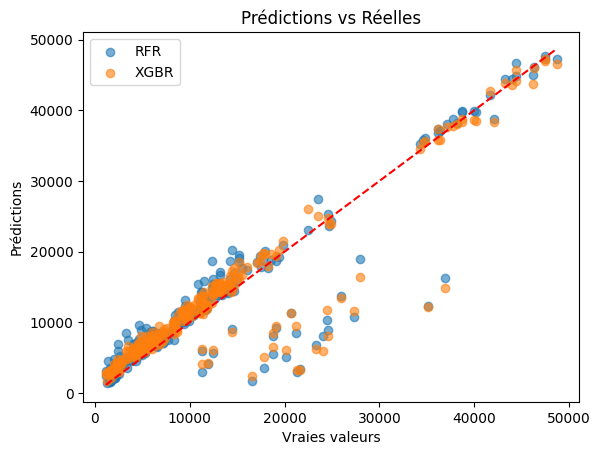

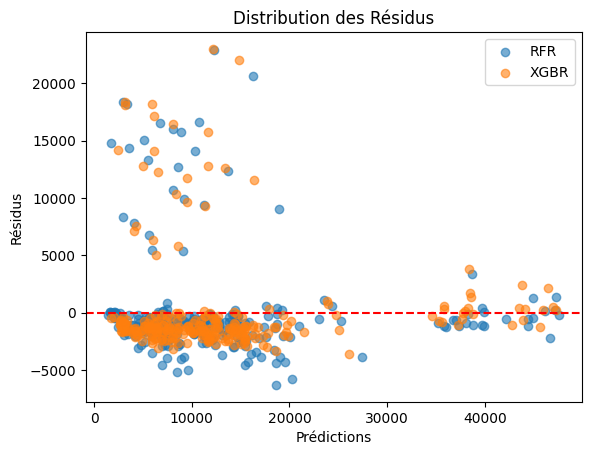

In [159]:
print("Avant : \n", df_res[0:2])
print("Apres : \n", df_optimises_file)


for pred in y_preds:
    model_name = pred['model']
    y_pred = pred['y_pred']
    plt.scatter(y_test, y_pred, alpha=0.6, label=model_name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Réelles')
plt.legend()
plt.show()

# 2. Graphique des résidus
plt.figure()
for pred in y_preds:
    model_name = pred['model']
    y_pred = pred['y_pred']
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6, label=model_name)

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Distribution des Résidus')
plt.legend()
plt.show()

Après l'optimisation je selectionne le model XGBR , car : 
* ✅ Meilleur RMSE : 4455.50 (vs 4528.87 pour RFR)

* ✅ Meilleur R² : 0.8331 (vs 0.8275 pour RFR)

* ✅ Plus grande amélioration 

* ✅ Performance et robustesse optimales

## ➕ Feature Story 5 : Test et Téléchargement du Modèle


### 1️⃣ Exporter le modèle dans un format standard :

In [160]:
import joblib
import pandas as pd

modele_final = None
meilleurs_params = None

for result in resultats_optimises:
    if result['model'] == 'XGBR':
        modele_final = next(m for m in [model_cv.best_estimator_] if m is not None)
        meilleurs_params = result['best_params']
        break

joblib.dump(modele_final, 'modele_final_charges_medicales.pkl')
print("✅ Modèle sauvegardé: 'modele_final_charges_medicales.pkl'")


✅ Modèle sauvegardé: 'modele_final_charges_medicales.pkl'


### 2️⃣ Tester le modèle final :

In [161]:
modele_charge = joblib.load('modele_final_charges_medicales.pkl')

test_prediction = modele_charge.predict(X_test.iloc[[0]])
print(f"\n🔍 Test prédiction - Valeur réelle: {y_test.iloc[0]:.2f}, Prédiction: {test_prediction[0]:.2f}")



🔍 Test prédiction - Valeur réelle: 9447.25, Prédiction: 11787.12
